# Technical Notebook
#### Authors: Ian Reinert and Peter Haferl
#### Date: 25/09/2019
#### Data source: https://www.bjs.gov/content/data/ncrp/2004/da26521-0003.zip

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_curve
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from graph_bias import analyze_bias
from clean_explore import full_clean
from models_visuals import *

In [2]:
data = pd.read_csv('data/da26521-0003.tsv', sep='\t', header=0)

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (95,96,97,98) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Report - Predicting Parole Completion

<em> Results: ~80% success rate in predicting parole completion in 2004 parole release data </em>
#### Most important features: 

### Assumptions
- Removing missing values (roughly 20% of the data) will not excessively bias results.
- It is valid to drop columns with missing value share greater than 0.20
- Colinearity between remaining time-related features will not excessively bias results
- Measurement error does not excessively bias results (data collected via filling out forms).

### Open issues/problems

- Trying to minimize implicit racial and gender bias.
- Possible leakage in data cleaning (data was not split before clean).
- More rigorous SVM optimization

### Analysis

<b>Our steps were as follows:</b><br>
<b> 1. Clean and explore data</b> - notable steps were replacing life sentences (coded '99999') with the 2004 average life sentence of 29 years (https://www.opensocietyfoundations.org/publications/meaning-life-long-prison-sentences-context), labeling our outcome variable as either 1 (parole completed) or 0 (state supervision continues) dropping variables that were contingent on our outcome variable (e.g. time served on parole, age at parole release), and removing gender and race variables.<br>
<b> 2. Running a baseline logistic regression model</b>: <em>Accuracy: 70% </em><br>
<b> 3. Building optimized models</b>: <em> Best Optimized Model (random forest) Accuracy: 80%

In [4]:
data_clean = full_clean()

In [5]:
X = data_clean.drop(columns='outcome')
y = data_clean['outcome']

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

## Baseline Model: Logistic Regression

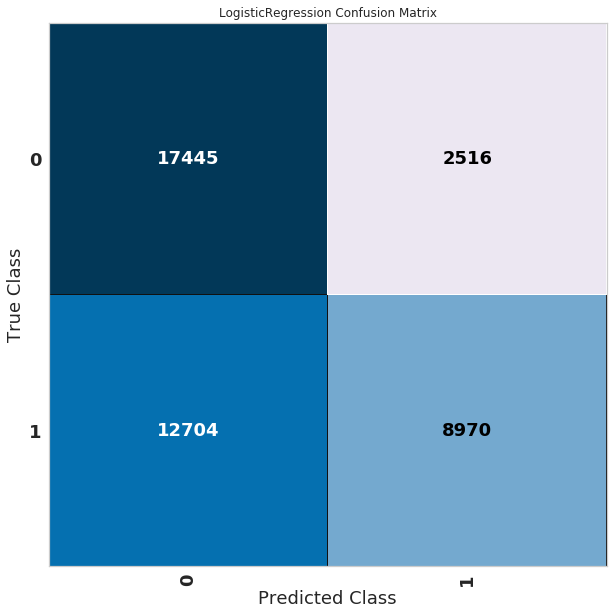

Baseline logistic regression classification report: 
               precision    recall  f1-score   support

           0       0.58      0.87      0.70     19961
           1       0.78      0.41      0.54     21674

    accuracy                           0.63     41635
   macro avg       0.68      0.64      0.62     41635
weighted avg       0.68      0.63      0.62     41635



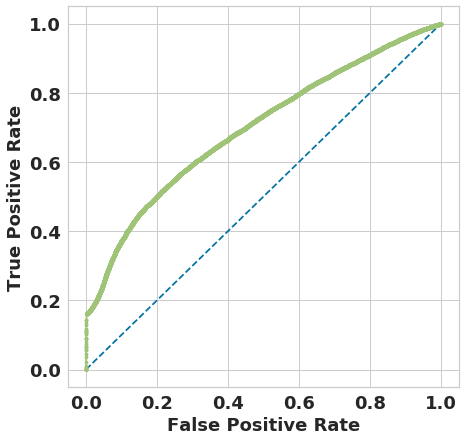

In [21]:
baseline_model = baseline_logistic(X_train, X_test, y_train, y_test)
roc_visual(baseline_model, X_train, X_test, y_test)

## Random Forest Model

### Random Forest Classifier Training

#### Grid Search for Params

In [6]:
# Set parameters for GridSearchCV to investigate

params = {
    'max_features' : ['auto', 'log2'],
    'criterion' : ['gini', 'entropy'],
    'n_estimators' : [150],
    'max_depth' : [1, 10, 100, 1000, None]
}

In [7]:
# Define GridSearchCV Object and Parameters

search = GridSearchCV(estimator=RandomForestClassifier(),
                     scoring='accuracy',
                     param_grid=params,
                     cv=5,
                     return_train_score=True,
                     verbose=True,
                     n_jobs=-1)

In [ ]:
search.fit(X_train, y_train)

#### Random Forest Model

In [8]:
# Set RandomForest model based on GridSearchCV results

rfc = RandomForestClassifier(criterion='entropy', max_depth=100, max_features='auto', n_estimators=150, n_jobs=-1)

In [9]:
# Fit model

rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=100, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [22]:
#View Important Features

features = pd.DataFrame([rfc.feature_importances_, data_clean.columns]).T
features = features.set_index(keys=features[1]).drop(columns=[1])
features.sort_values(by=0, ascending=False).head(5)

,0
1,
time_served_current_admission,0.13017
age_admission,0.10803
age_prison_release,0.107629
year_prison_release,0.0953315
admission_year,0.0864756


In [10]:
# Get train predictions from model

y_train_pred = rfc.predict(X_train)

In [11]:
# Analyze results via confustion matrix

confusion_matrix(y_train, y_train_pred)

array([[59949,    18],
       [   22, 64913]])

In [12]:
# Analyze results via precision/recall/fl_score

print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     59967
           1       1.00      1.00      1.00     64935

   micro avg       1.00      1.00      1.00    124902
   macro avg       1.00      1.00      1.00    124902
weighted avg       1.00      1.00      1.00    124902



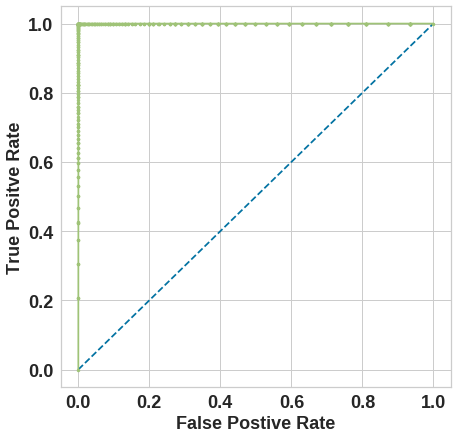

In [14]:
# Graph ROC curve for model

probs_train = rfc.predict_proba(X_train)[:,1]

font = {'weight' : 'bold',
        'size'   : 18}

plt.rc('font', **font)
plt.figure(figsize=(7,7))
plt.ylabel('True Positve Rate', fontdict=font)
plt.xlabel('False Postive Rate', fontdict=font)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

fpr, tpr, thresholds = roc_curve(y_train, probs_train)
# Plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# Plot the roc curve for the model
plt.plot(fpr, tpr, marker='.')
# Show the plot
plt.show()

### Random Forest Classifier Testing

In [15]:
# Get test results

y_test_pred = rfc.predict(X_test)

In [16]:
# Analyze results via confustion matrix

confusion_matrix(y_test, y_test_pred)

array([[16554,  3414],
       [ 4374, 17293]])

In [17]:
# Analyze results via precision/recall/fl_score

print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.79      0.83      0.81     19968
           1       0.84      0.80      0.82     21667

   micro avg       0.81      0.81      0.81     41635
   macro avg       0.81      0.81      0.81     41635
weighted avg       0.81      0.81      0.81     41635



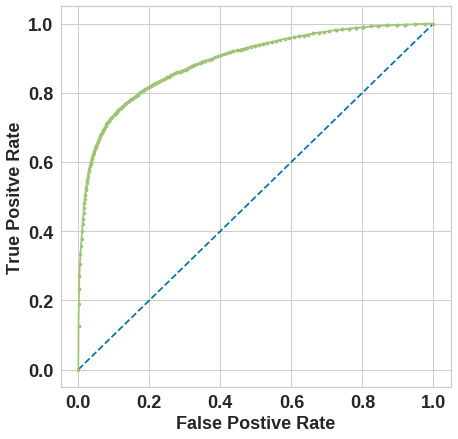

In [19]:
# Graph ROC curve for model

probs_test = rfc.predict_proba(X_test)[:,1]

font = {'weight' : 'bold',
        'size'   : 18}

plt.rc('font', **font)
plt.figure(figsize=(7,7))
plt.ylabel('True Positve Rate', fontdict=font)
plt.xlabel('False Postive Rate', fontdict=font)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

fpr, tpr, thresholds = roc_curve(y_test, probs_test)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.')

plt.savefig('random_forest_ROC.png', transparent=True)
# show the plot
plt.show()

# plt.savefig('random_forest_ROC.png', transparent=True)

### Bias Analysis

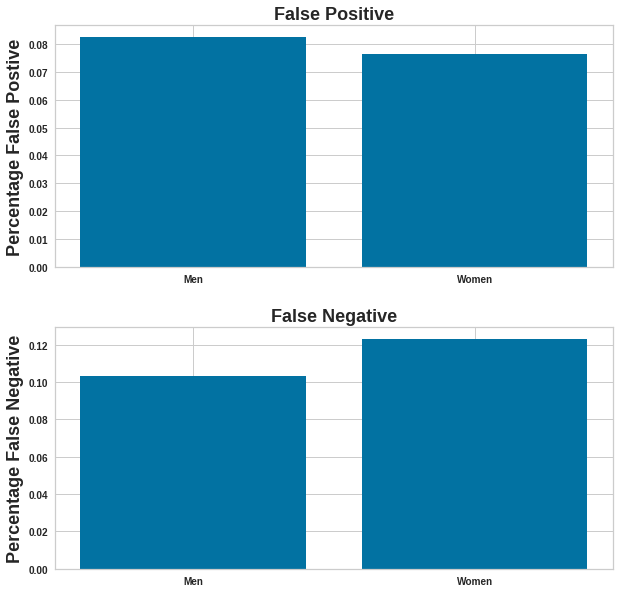

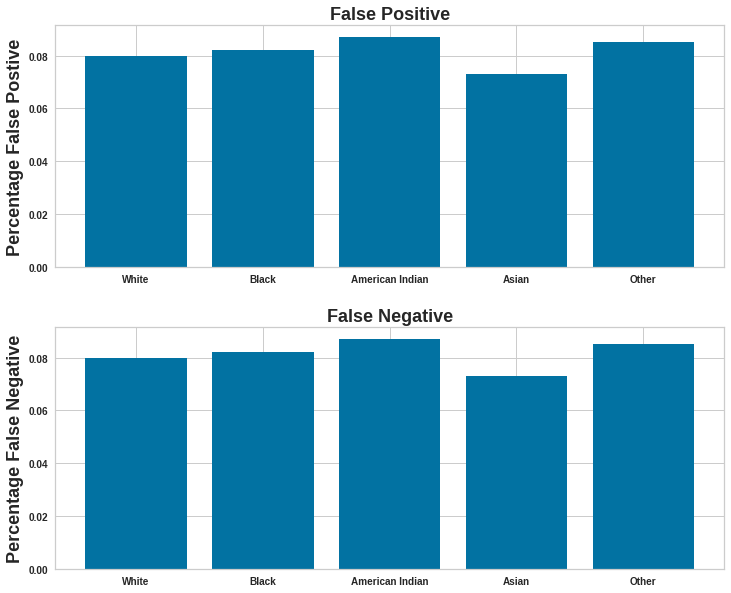

In [20]:
analyze_bias(y_test, y_test_pred)

## SVC Model

### Training

In [6]:
warnings.simplefilter('ignore')

scaled_X_train = StandardScaler().fit_transform(X_train)

In [7]:
test = LinearSVC(C=1, penalty="l1", dual=False, max_iter=10000).fit(scaled_X_train, y_train)

In [10]:
train_predict = test.predict(scaled_X_train)

In [12]:
confusion_matrix(y_train, train_predict)

array([[53213,  6759],
       [18076, 46854]])

In [13]:
print(classification_report(y_train, train_predict))

              precision    recall  f1-score   support

           0       0.75      0.89      0.81     59972
           1       0.87      0.72      0.79     64930

   micro avg       0.80      0.80      0.80    124902
   macro avg       0.81      0.80      0.80    124902
weighted avg       0.81      0.80      0.80    124902



### Test

In [14]:
warnings.simplefilter('ignore')

scaled_X_test = StandardScaler().fit_transform(X_test)

In [21]:
y_test_pred = test.predict(scaled_X_test)

In [22]:
confusion_matrix(y_test, test_predict)

array([[17668,  2295],
       [ 6066, 15606]])

In [23]:
print(classification_report(y_test, test_predict))

              precision    recall  f1-score   support

           0       0.74      0.89      0.81     19963
           1       0.87      0.72      0.79     21672

   micro avg       0.80      0.80      0.80     41635
   macro avg       0.81      0.80      0.80     41635
weighted avg       0.81      0.80      0.80     41635



### Bias Analysis

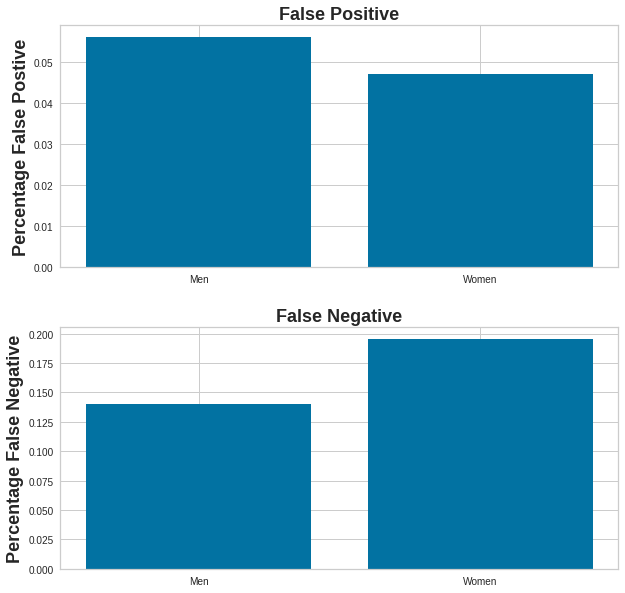

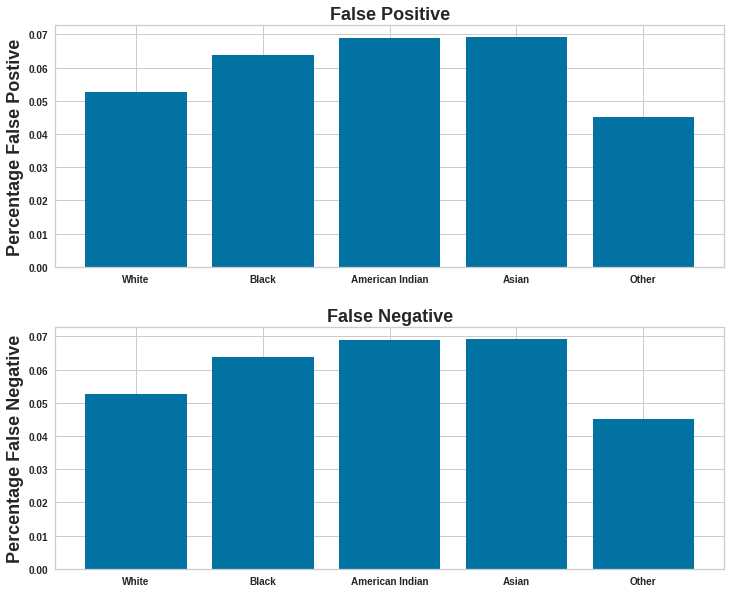

In [24]:
analyze_bias(y_test, y_test_pred)